In [1]:
import pandas as pd
import numpy as np
import requests
import hopsworks
import joblib

In [2]:
%load_ext autoreload
%autoreload 2
%cd .. 

/Users/manu/Desktop/Projects/ServerlessML/projects/air_quality


# Importing Air Qualtiy Dataset for Gothenburg year 2023
##### https://goteborg.se/wps/portal/start/kommun-och-politik/sa-arbetar-goteborgs-stad-med/digitalisering/oppna-data/sok-oppna-data/oppna-data---datamangd#esc_entry=690&esc_context=6

In [3]:
df = pd.read_csv("air_quality_2023.csv", skipinitialspace=True)

In [4]:
df.head()

,Date,Time,Femman_Temp,Femman_RH,Femman_GlobRad,Femman_AirPressure,Femman_WindSpeed,Femman_WindDir,Femman_Rain,Femman_NO2,...,Mobil1_NO2,Mobil1_NOx,Mobil1_PM10,Mobil2_NO2,Mobil2_NOx,Mobil2_PM10,Mobil3_NO2,Mobil3_NOx,Mobil3_PM10,Mobil2_PM25
0,2023-01-01,01:00+01:00,5.481,98.0,0.0,997.474,1.639,207.9,0.0,14.10300,...,16.6152,15.8849,26.70540,7.78893,7.68050,15.21330,27.00530,32.40550,152.85600,10.89460
1,2023-01-01,02:00+01:00,5.529,99.3,0.0,997.362,2.309,191.2,0.0,10.47370,...,17.6177,16.5370,15.78380,11.03920,11.29170,15.00430,12.64720,14.52610,21.35180,11.82110
2,2023-01-01,03:00+01:00,5.545,100.0,0.0,997.512,1.552,194.6,0.0,9.72116,...,16.3276,15.4368,6.63315,9.16142,9.16124,8.64975,11.11030,12.27120,9.56303,6.21183
3,2023-01-01,04:00+01:00,5.488,99.8,0.0,997.548,1.245,185.3,0.0,7.69565,...,15.0220,14.3629,4.01427,6.72511,6.13341,8.64890,9.45273,12.31570,5.17778,6.42150
4,2023-01-01,05:00+01:00,5.459,93.6,0.0,997.622,1.385,198.4,0.0,5.33080,...,12.9767,13.5176,0.97035,4.11213,3.65649,7.76768,6.28138,6.25854,1.25138,4.60312


In [5]:
df.columns

Index(['Date', 'Time', 'Femman_Temp', 'Femman_RH', 'Femman_GlobRad',
       'Femman_AirPressure', 'Femman_WindSpeed', 'Femman_WindDir',
       'Femman_Rain', 'Femman_NO2', 'Femman_O3', 'Femman_PM10', 'Femman_NOx',
       'Femman_PM25', 'HagaNorra_NO2', 'HagaNorra_NOx', 'HagaSodra_PM10',
       'HagaSodra_PM25', 'Lejonet_GlobRad', 'Lejonet_AirPressure',
       'Lejonet_Rain', 'Lejonet_RH', 'Lejonet_Temp', 'Lejonet_WindDir',
       'Lejonet_WindSpeed', 'Mobil1_NO2', 'Mobil1_NOx', 'Mobil1_PM10',
       'Mobil2_NO2', 'Mobil2_NOx', 'Mobil2_PM10', 'Mobil3_NO2', 'Mobil3_NOx',
       'Mobil3_PM10', 'Mobil2_PM25  '],
      dtype='object')

# EDA

#### Setting Femman_PM25 as the prediction variable

In [6]:
len(df)

7089

In [7]:
df.describe()

,Femman_Temp,Femman_RH,Femman_GlobRad,Femman_AirPressure,Femman_WindSpeed,Femman_WindDir,Femman_Rain,Femman_NO2,Femman_O3,Femman_PM10,...,Mobil1_NO2,Mobil1_NOx,Mobil1_PM10,Mobil2_NO2,Mobil2_NOx,Mobil2_PM10,Mobil3_NO2,Mobil3_NOx,Mobil3_PM10,Mobil2_PM25
count,7062.000000,7062.000000,7062.000000,7062.000000,7061.000000,7062.000000,7059.000000,7057.000000,1968.000000,7031.000000,...,6999.000000,6999.000000,6988.000000,5192.000000,5192.000000,5212.000000,6957.000000,6959.000000,6279.000000,5212.000000
mean,11.123717,72.886192,136.370605,1010.124582,3.481418,174.151901,0.101941,10.577004,57.345923,13.775425,...,14.058839,19.804184,14.444139,9.151443,11.719978,11.503529,12.775606,17.289357,15.390835,5.785804
std,6.933409,20.024597,214.063297,12.170520,1.786483,88.568515,0.471013,10.361669,25.301261,10.902743,...,11.706563,23.968551,15.785046,7.693551,15.297418,8.532280,10.469983,21.905406,12.841025,4.566387
min,-6.582000,15.640000,0.000000,970.752000,0.232000,0.122000,0.000000,0.379720,-15.185100,-33.534400,...,-2.025160,-3.251070,-20.398800,0.346224,-0.005478,0.129300,1.088640,1.073340,-74.443000,0.083850
25%,5.416250,59.282500,0.000000,1002.450000,2.074000,114.325000,0.000000,4.368820,44.958475,7.810340,...,6.448700,7.071930,5.297400,4.266223,4.777185,5.815070,6.094150,7.153770,7.750875,2.812387
50%,12.555000,75.950000,14.730000,1011.240000,3.299000,192.450000,0.000000,7.176500,60.310300,12.148000,...,10.713300,13.294500,11.244000,6.826105,7.758265,9.912265,9.576690,11.602200,13.212900,4.695700
75%,16.890000,89.200000,192.250000,1018.747500,4.581000,237.675000,0.000000,12.583400,73.156050,17.423650,...,17.500200,24.135500,19.365500,11.250950,13.174925,15.099825,15.698100,19.011850,19.825450,7.642527
max,27.720000,100.000000,893.000000,1038.320000,12.800000,359.900000,11.000000,122.918000,163.305000,361.687000,...,111.461000,359.182000,283.205000,67.284300,218.407000,230.407000,117.425000,399.201000,179.445000,67.581800


In [8]:
# Finding percentage of na
df.isna().sum() / len(df) * 100

Date                    0.000000
Time                    0.000000
Femman_Temp             0.380872
Femman_RH               0.380872
Femman_GlobRad          0.380872
Femman_AirPressure      0.380872
Femman_WindSpeed        0.394978
Femman_WindDir          0.380872
Femman_Rain             0.423191
Femman_NO2              0.451404
Femman_O3              72.238680
Femman_PM10             0.818169
Femman_NOx              0.451404
Femman_PM25             0.578361
HagaNorra_NO2           0.380872
HagaNorra_NOx           0.380872
HagaSodra_PM10          7.095500
HagaSodra_PM25         16.490337
Lejonet_GlobRad         0.000000
Lejonet_AirPressure     0.000000
Lejonet_Rain            0.000000
Lejonet_RH              0.000000
Lejonet_Temp            0.000000
Lejonet_WindDir         0.000000
Lejonet_WindSpeed       0.000000
Mobil1_NO2              1.269573
Mobil1_NOx              1.269573
Mobil1_PM10             1.424743
Mobil2_NO2             26.759769
Mobil2_NOx             26.759769
Mobil2_PM1

In [9]:
# Finding corrleation with prediction variable
df.drop(['Date', 'Time'], axis = 1).corr()["Femman_PM25"].sort_values()

Femman_WindSpeed      -0.094391
Lejonet_WindSpeed     -0.093493
Femman_Rain           -0.032225
Lejonet_WindDir       -0.025657
Lejonet_Rain          -0.015662
Femman_WindDir        -0.014857
Lejonet_RH             0.018249
Femman_GlobRad         0.027761
Lejonet_GlobRad        0.027824
Femman_RH              0.032217
Mobil1_NOx             0.050883
Femman_NOx             0.068196
Mobil1_NO2             0.074498
Mobil2_NOx             0.074797
Mobil3_NOx             0.078761
Mobil1_PM10            0.083609
HagaNorra_NOx          0.086677
Femman_NO2             0.092222
Mobil3_NO2             0.101988
Femman_O3              0.105246
Femman_AirPressure     0.105914
Lejonet_AirPressure    0.106442
HagaNorra_NO2          0.114472
Lejonet_Temp           0.119856
Femman_Temp            0.119966
Mobil2_NO2             0.127964
Mobil3_PM10            0.149281
HagaSodra_PM25         0.241008
Mobil2_PM10            0.255727
HagaSodra_PM10         0.258154
Mobil2_PM25            0.408895
Femman_P

<Axes: ylabel='Frequency'>

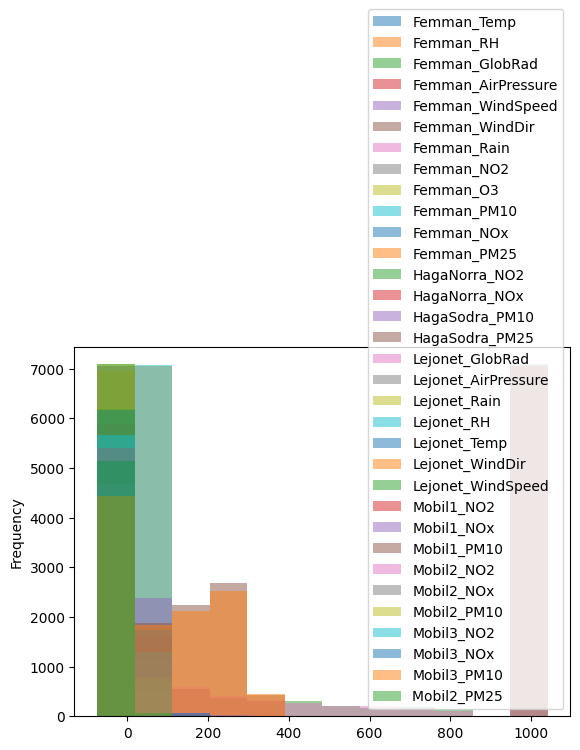

In [35]:
import matplotlib.pyplot as plt
df.plot.hist(bins=12, alpha=0.5)

# Feature Engineering

In [12]:
from air_pred.utils import data_preprocessing

### Baseline Features

In [13]:
baseline_feature = df.drop(['Femman_O3'], axis=1) # dropping this feature since it has a high percentage of invalid samples
baseline_feature = data_preprocessing.create_date_time_feature(baseline_feature).sort_values("date_time")
baseline_feature = baseline_feature.interpolate()

### KNN Imputer features

In [14]:
knn_imputer_feature = df.drop(['Femman_O3'], axis=1) # dropping this feature since it has a high percentage of invalid samples
knn_imputer_feature = data_preprocessing.create_date_time_feature(knn_imputer_feature).sort_values("date_time")
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
date_time = knn_imputer_feature.date_time
date_time_str = knn_imputer_feature.date_time_str
knn_imputer_feature = knn_imputer_feature.drop(['date_time', 'date_time_str'], axis=1)
knn_imputer_feature[:] = imputer.fit_transform(knn_imputer_feature)
knn_imputer_feature['date_time'] = date_time
knn_imputer_feature['date_time_str'] = date_time_str
knn_imputer_feature.isna().sum()

femman_temp            0
femman_rh              0
femman_globrad         0
femman_airpressure     0
femman_windspeed       0
femman_winddir         0
femman_rain            0
femman_no2             0
femman_pm10            0
femman_nox             0
femman_pm25            0
haganorra_no2          0
haganorra_nox          0
hagasodra_pm10         0
hagasodra_pm25         0
lejonet_globrad        0
lejonet_airpressure    0
lejonet_rain           0
lejonet_rh             0
lejonet_temp           0
lejonet_winddir        0
lejonet_windspeed      0
mobil1_no2             0
mobil1_nox             0
mobil1_pm10            0
mobil2_no2             0
mobil2_nox             0
mobil2_pm10            0
mobil3_no2             0
mobil3_nox             0
mobil3_pm10            0
mobil2_pm25            0
date_time              0
date_time_str          0
dtype: int64

### Multi variate fearure imputation

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mutivariate_imputer_feature = df.drop(['Femman_O3'], axis=1) # dropping this feature since it has a high percentage of invalid samples
mutivariate_imputer_feature = data_preprocessing.create_date_time_feature(mutivariate_imputer_feature).sort_values("date_time")

imputer = IterativeImputer(max_iter=10, random_state=0)
date_time = mutivariate_imputer_feature.date_time
date_time_str = mutivariate_imputer_feature.date_time_str

mutivariate_imputer_feature = mutivariate_imputer_feature.drop(['date_time', 'date_time_str'], axis=1)
mutivariate_imputer_feature[:] = imputer.fit_transform(mutivariate_imputer_feature)
mutivariate_imputer_feature['date_time'] = date_time
mutivariate_imputer_feature['date_time_str'] = date_time_str

mutivariate_imputer_feature.isna().sum()

femman_temp            0
femman_rh              0
femman_globrad         0
femman_airpressure     0
femman_windspeed       0
femman_winddir         0
femman_rain            0
femman_no2             0
femman_pm10            0
femman_nox             0
femman_pm25            0
haganorra_no2          0
haganorra_nox          0
hagasodra_pm10         0
hagasodra_pm25         0
lejonet_globrad        0
lejonet_airpressure    0
lejonet_rain           0
lejonet_rh             0
lejonet_temp           0
lejonet_winddir        0
lejonet_windspeed      0
mobil1_no2             0
mobil1_nox             0
mobil1_pm10            0
mobil2_no2             0
mobil2_nox             0
mobil2_pm10            0
mobil3_no2             0
mobil3_nox             0
mobil3_pm10            0
mobil2_pm25            0
date_time              0
date_time_str          0
dtype: int64

### PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
def pca_features(base_df, n_components):
    pca = PCA(n_components=10)
    pca.fit(knn_imputer_feature.drop(['date_time', 'date_time_str','femman_pm25'], axis = 1))
    features = pd.DataFrame(pca.transform(baseline_feature.drop(['date_time', 'date_time_str','femman_pm25'], axis = 1)))
    features['femman_pm25'] = base_df.femman_pm25
    features['date_time'] = base_df.date_time
    features['date_time_str'] = base_df.date_time_str
    return features

### Polynomial Features

In [18]:
from sklearn.preprocessing import PolynomialFeatures
def polynomial_features(base_df, degree):
    features = pd.DataFrame(base_df.drop(['date_time', 'date_time_str','femman_pm25'], axis = 1))
    poly = PolynomialFeatures(2)
    features = pd.DataFrame(poly.fit_transform(features), columns=poly.get_feature_names_out(features.columns)).drop('1', axis = 1)
    features['femman_pm25'] = base_df.femman_pm25
    features['date_time'] = base_df.date_time
    features['date_time_str'] = base_df.date_time_str
    return features

### Gaussian Transformation

In [19]:
from sklearn.preprocessing import QuantileTransformer
def gaussian_transformation(base_df):
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    features = pd.DataFrame(base_df.drop(['date_time', 'date_time_str','femman_pm25'], axis = 1))
    features[:] = quantile_transformer.fit_transform(features)
    features['femman_pm25'] = base_df.femman_pm25
    features['date_time'] = base_df.date_time
    features['date_time_str'] = base_df.date_time_str
    return features

### Time series Features

In [308]:
base_ts_features = mutivariate_imputer_feature[['date_time','femman_pm25']].sort_values("date_time")
base_ts_features = base_ts_features.set_index('date_time', drop=False)

In [309]:
base_ts_features["prev_day"] = base_ts_features.femman_pm25.shift(periods=24)
base_ts_features["prev_week"] = base_ts_features.femman_pm25.shift(periods=168)
base_ts_features

,date_time,femman_pm25,prev_day,prev_week
date_time,,,,
2023-01-01 01:00:00,2023-01-01 01:00:00,31.094700,NaN,NaN
2023-01-01 02:00:00,2023-01-01 02:00:00,32.775800,NaN,NaN
2023-01-01 03:00:00,2023-01-01 03:00:00,11.785700,NaN,NaN
2023-01-01 04:00:00,2023-01-01 04:00:00,5.929210,NaN,NaN
2023-01-01 05:00:00,2023-01-01 05:00:00,4.669400,NaN,NaN
...,...,...,...,...
2023-10-23 05:00:00,2023-10-23 05:00:00,1.996630,1.374300,2.64613
2023-10-23 06:00:00,2023-10-23 06:00:00,1.140470,0.296751,4.14768
2023-10-23 07:00:00,2023-10-23 07:00:00,-0.274416,-1.337530,5.90919


In [310]:
base_ts_features = base_ts_features.dropna()

In [355]:
from sklearn import linear_model
target = base_ts_features.femman_pm25
features = base_ts_features.drop(["femman_pm25"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=False)

model = linear_model.LinearRegression().fit(X_train.drop(["date_time"], axis = 1), y_train)

pred_train = model.predict(X_train.drop(["date_time"], axis = 1))
train_error = mean_squared_error(pred_train,y_train)
pred_test = model.predict(X_test.drop(["date_time"], axis = 1))
test_error = mean_squared_error(pred_test,y_test)
print(f'train erro : {train_error}, test error : {test_error}')
print(features.columns)
model.coef_

train erro : 19.825276486311832, test error : 180.9072512068849
Index(['date_time', 'prev_day', 'prev_week'], dtype='object')


array([0.31923559, 0.11451583])

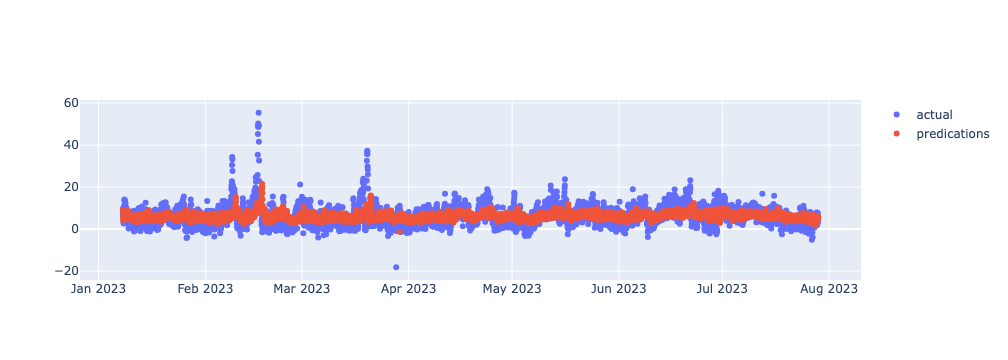

In [356]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=X_train.date_time, y=y_train,
                    mode='markers',
                    name='actual'))
fig.add_trace(go.Scatter(x=X_train.date_time, y=pred_train,
                    mode='markers',
                    name='predications'))

fig.show()

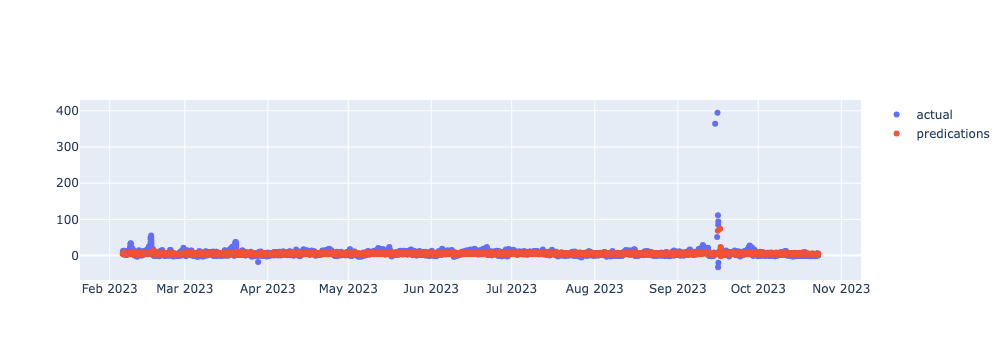

In [344]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=X_test.date_time, y=y_test,
                    mode='markers',
                    name='actual'))
fig.add_trace(go.Scatter(x=X_test.date_time, y=pred_test,
                    mode='markers',
                    name='predications'))

fig.show()

### Rolling window features

In [21]:
def rolling_window_feature(base_df, window_len, allfeature=True):
    if allfeature:   
        rolling_window_features = base_df.copy()
    else:
        rolling_window_features = pd.DataFrame()
        rolling_window_features['date_time'] = base_df.date_time
        rolling_window_features['date_time_str'] = base_df.date_time_str
        rolling_window_features['femman_pm25'] = base_df.femman_pm25
    for feature in knn_imputer_feature.columns:
        if feature not in ['date_time', 'date_time_str','femman_pm25']:
            rolling_window_features['rolling_'+feature] = base_df[feature].rolling(2,min_periods=1).sum()
    return rolling_window_features

# Feature Selection

### Feature Selection Variance Threshold

In [22]:
from sklearn.feature_selection import VarianceThreshold

In [23]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
variance_threshold_df = sel.fit_transform(baseline_feature.drop(['date_time', 'date_time_str','femman_pm25'], axis = 1))

In [24]:
variance_threshold_df

array([[  5.481  ,  98.     ,   0.     , ...,  32.4055 , 152.856  ,
         10.8946 ],
       [  5.529  ,  99.3    ,   0.     , ...,  14.5261 ,  21.3518 ,
         11.8211 ],
       [  5.545  , 100.     ,   0.     , ...,  12.2712 ,   9.56303,
          6.21183],
       ...,
       [ 10.04   , 100.     ,   3.198  , ...,  21.3607 ,  14.939  ,
          3.26125],
       [ 10.4    ,  99.8    ,  21.3    , ...,  16.6173 ,  14.939  ,
          4.01006],
       [ 10.4    , 100.     ,  25.49   , ...,  24.0582 ,  14.939  ,
          5.6358 ]])

### K Best Features

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

In [26]:
def k_best_features(feature_df, train_func, plotting = False, verbose = True):
    train_df = feature_df.drop(['date_time', 'date_time_str','femman_pm25'], axis = 1)
    test_df = feature_df.femman_pm25
    optimal_model = None
    min_test_error = None
    train_erros = []
    test_erros = []
    for i in range(1, len(train_df.columns)):
        train_df_new = SelectKBest(f_regression, k=i).fit_transform(train_df, test_df)
        X_train, X_test, y_train, y_test = train_test_split(train_df_new, test_df, test_size=0.33, shuffle=True)

        model = train_func(X_train, y_train)

        pred_train = model.predict(X_train)
        train_error = mean_squared_error(pred_train,y_train)
        pred_test = model.predict(X_test)
        test_error = mean_squared_error(pred_test,y_test)
        train_erros.append(train_error)
        if min_test_error is None:
            min_test_error = test_error
            optimal_model = model
        else:
            if test_error < min_test_error:
                min_test_error = test_error
                optimal_model = model
        test_erros.append(test_error)
    if plotting:
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=train_erros, x=[*range(1,32)],
                            mode='lines',
                            name='Training error'))
        fig.add_trace(go.Scatter(y=test_erros, x=[*range(1,32)],
                            mode='lines',
                            name='Testing error'))
        fig.show()
    optimal_k = test_erros.index(min(test_erros)) + 1
    
    

    selector = SelectKBest(f_regression, k=optimal_k).fit(train_df, test_df).get_support()

    new_features = train_df.columns[selector]
    feature_list = list(set(train_df.columns) - set(new_features))
    if verbose:
        print(f'Optimal Number of Features : {optimal_k}')
        print(f'Test Error : {min(test_erros)}')
        print(f'Train Error : {train_erros[optimal_k-1]}')
        print(f'Removed Feature : {feature_list}')

    return optimal_model, min(test_erros)

# Prediction Models

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

### Baseline Prediction model

In [31]:
def train_linear_regression(X_train, y_train):
    reg = LinearRegression().fit(X_train, y_train)
    return reg

In [152]:
# Best model with baseline features
optimal_model, min_error = k_best_features(baseline_feature, train_linear_regression)

Optimal Number of Features : 22
Test Error : 15.37218205501442
Train Error : 23.73983425538425
Selected Feature : ['lejonet_rain', 'femman_globrad', 'hagasodra_pm10', 'mobil2_nox', 'femman_nox', 'mobil1_nox', 'lejonet_winddir', 'femman_winddir', 'lejonet_globrad']


In [153]:
optimal_model, min_error = k_best_features(knn_imputer_feature, train_linear_regression)

Optimal Number of Features : 6
Test Error : 13.251940917839082
Train Error : 20.936285053480745
Selected Feature : ['lejonet_rain', 'femman_airpressure', 'femman_no2', 'mobil1_no2', 'hagasodra_pm25', 'femman_nox', 'femman_windspeed', 'lejonet_winddir', 'lejonet_temp', 'lejonet_windspeed', 'lejonet_airpressure', 'mobil3_no2', 'lejonet_globrad', 'femman_globrad', 'femman_rain', 'mobil2_nox', 'mobil3_nox', 'mobil1_nox', 'haganorra_no2', 'lejonet_rh', 'haganorra_nox', 'femman_rh', 'mobil1_pm10', 'femman_winddir', 'femman_temp']


In [138]:
optimal_model, min_error = k_best_features(mutivariate_imputer_feature, train_linear_regression)

Optimal Number of Features : 23
Test Error : 8.538770470384016
Train Error : 13.29194591930145
Removed Feature : ['lejonet_globrad', 'lejonet_rain', 'femman_rain', 'lejonet_rh', 'lejonet_winddir', 'femman_rh', 'femman_winddir', 'femman_globrad']


In [120]:
gausian_features = gaussian_transformation(knn_imputer_feature)
optimal_model, min_error = k_best_features(gausian_features, train_linear_regression)

Optimal Number of Features : 19
Test Error : 13.075002425288023
Train Error : 70.98216053591824
Removed Feature : ['lejonet_globrad', 'lejonet_rain', 'femman_rain', 'mobil1_no2', 'lejonet_rh', 'lejonet_winddir', 'femman_rh', 'femman_winddir', 'lejonet_windspeed', 'femman_globrad', 'mobil1_nox', 'femman_windspeed']


In [167]:
base_df = baseline_feature
min_error_final, optimal_number_components = None, None
for n_components in range(len(base_df.columns)-3):
    features = pca_features(base_df, n_components)
    optimal_model, min_error = k_best_features(features, train_linear_regression, verbose=False)
    if min_error_final is None:
        min_error_final = min_error
        optimal_number_components = n_components
    else:
        if min_error < min_error_final:
            min_error_final = min_error
            optimal_number_components = n_components
print(f'Min Error: {min_error_final}')
print(f'optimal_number_components : {optimal_number_components}')

Min Error: 78.66152953502016
optimal_number_components : 3


In [169]:
base_df = knn_imputer_feature
min_error_final, optimal_number_components = None, None
for n_components in range(len(base_df.columns)-3):
    features = pca_features(base_df, n_components)
    optimal_model, min_error = k_best_features(features, train_linear_regression, verbose=False)
    if min_error_final is None:
        min_error_final = min_error
        optimal_number_components = n_components
    else:
        if min_error < min_error_final:
            min_error_final = min_error
            optimal_number_components = n_components
print(f'Min Error: {min_error_final}')
print(f'optimal_number_components : {optimal_number_components}')

Min Error: 18.730012154221388
optimal_number_components : 20


In [32]:
base_df = mutivariate_imputer_feature
min_error_final, optimal_window_len, optimal_window_all_features = None, None, None
for allfeature in [True, False]:
    for window_len in range(1,20):
        print(f'Current : {window_len}, {allfeature}', end='\r')
        features = rolling_window_feature(base_df, window_len, allfeature = allfeature)
        optimal_model, min_error = k_best_features(features, train_linear_regression, verbose=False)
        if min_error_final is None:
            min_error_final = min_error
            optimal_window_len = window_len
            optimal_window_all_features = allfeature
        else:
            if min_error < min_error_final:
                min_error_final = min_error
                optimal_window_len = window_len
                optimal_window_all_features = allfeature
print(f'Min Error: {min_error_final}')
print(f'optimal_window_len : {optimal_window_len}')
print(f'optimal_window_all_features : {optimal_window_all_features}')

Min Error: 7.279204718228792
optimal_window_len : 19
optimal_window_all_features : True


In [187]:
base_df = knn_imputer_feature
min_error_final, optimal_window_len, optimal_window_all_features = None, None, None
for allfeature in [True, False]:
    for window_len in range(0,20):
        print(f'Current : {window_len}, {allfeature}', end='\r')
        features = rolling_window_feature(base_df, window_len, allfeature = allfeature)
        optimal_model, min_error = k_best_features(features, train_linear_regression, verbose=False)
        if min_error_final is None:
            min_error_final = min_error
            optimal_window_len = window_len
            optimal_window_all_features = allfeature
        else:
            if min_error < min_error_final:
                min_error_final = min_error
                optimal_window_len = window_len
                optimal_window_all_features = allfeature
print(f'Min Error: {min_error_final}')
print(f'optimal_window_len : {optimal_window_len}')
print(f'optimal_window_all_features : {optimal_window_all_features}')

Min Error: 8.528667810022336
optimal_window_len : 17
optimal_window_all_features : True


In [122]:
features = polynomial_features(knn_imputer_feature, 2)
optimal_model, min_error = k_best_features(features, train_linear_regression, verbose=True)

Optimal Number of Features : 242
Test Error : 4.484194633228467
Train Error : 3.8111707264059422
Removed Feature : ['femman_globrad mobil1_pm10', 'haganorra_no2 lejonet_winddir', 'femman_winddir mobil3_nox', 'lejonet_globrad mobil2_pm10', 'lejonet_rain lejonet_rh', 'femman_windspeed mobil3_nox', 'lejonet_windspeed mobil3_nox', 'femman_nox mobil1_pm10', 'mobil1_pm10 mobil3_pm10', 'femman_globrad femman_no2', 'mobil1_nox^2', 'femman_winddir femman_nox', 'lejonet_windspeed mobil2_nox', 'lejonet_temp lejonet_windspeed', 'lejonet_rain mobil3_nox', 'femman_globrad lejonet_winddir', 'femman_no2 mobil1_no2', 'hagasodra_pm10 lejonet_windspeed', 'femman_windspeed lejonet_globrad', 'mobil1_no2 mobil3_nox', 'mobil1_no2 mobil2_nox', 'femman_rain mobil1_no2', 'hagasodra_pm25 lejonet_globrad', 'femman_nox lejonet_winddir', 'femman_globrad mobil3_nox', 'mobil1_pm10 mobil2_nox', 'mobil1_nox mobil3_nox', 'mobil3_nox', 'femman_globrad^2', 'femman_airpressure lejonet_rain', 'femman_no2^2', 'femman_nox mob

### ML Model

In [323]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [28]:
def train_mlp(X_train, y_train):
    reg = MLPRegressor(random_state=1, max_iter=2000).fit(X_train, y_train)
    return reg

In [25]:
# Best model with baseline features
optimal_model, min_error = k_best_features(baseline_feature, train_mlp)

Optimal Number of Features : 25
Test Error : 5.067759338925554
Train Error : 6.080149461038573
Selected Feature : ['mobil1_nox', 'femman_winddir', 'lejonet_rain', 'femman_globrad', 'mobil2_nox', 'lejonet_globrad']


In [26]:
optimal_model, min_error = k_best_features(knn_imputer_feature, train_mlp)

Optimal Number of Features : 8
Test Error : 3.7669851499560476
Train Error : 3.287805639674383
Selected Feature : ['lejonet_winddir', 'mobil1_pm10', 'haganorra_nox', 'femman_windspeed', 'femman_rh', 'femman_airpressure', 'femman_nox', 'mobil2_nox', 'lejonet_globrad', 'lejonet_windspeed', 'femman_rain', 'haganorra_no2', 'lejonet_temp', 'mobil3_no2', 'lejonet_rain', 'femman_globrad', 'lejonet_rh', 'mobil1_no2', 'femman_no2', 'mobil1_nox', 'femman_winddir', 'mobil3_nox', 'lejonet_airpressure']


In [139]:
optimal_model, min_error = k_best_features(mutivariate_imputer_feature, train_mlp)

Optimal Number of Features : 10
Test Error : 3.234496386572833
Train Error : 2.7988157726984455
Removed Feature : ['lejonet_airpressure', 'mobil3_no2', 'lejonet_rh', 'femman_rh', 'femman_winddir', 'femman_globrad', 'mobil1_nox', 'lejonet_globrad', 'femman_no2', 'mobil3_nox', 'femman_windspeed', 'mobil1_no2', 'mobil2_nox', 'lejonet_windspeed', 'mobil1_pm10', 'femman_nox', 'lejonet_rain', 'femman_rain', 'haganorra_nox', 'femman_airpressure', 'lejonet_winddir']


In [29]:
gausian_features = gaussian_transformation(knn_imputer_feature)
optimal_model, min_error = k_best_features(gausian_features, train_mlp)

Optimal Number of Features : 13
Test Error : 4.536234243046072
Train Error : 2.8082995289449464
Removed Feature : ['femman_winddir', 'lejonet_windspeed', 'femman_rh', 'lejonet_airpressure', 'mobil1_nox', 'lejonet_rh', 'femman_no2', 'femman_windspeed', 'lejonet_winddir', 'lejonet_rain', 'mobil3_nox', 'lejonet_globrad', 'femman_nox', 'mobil1_no2', 'mobil1_pm10', 'femman_globrad', 'femman_airpressure', 'femman_rain']


In [25]:
base_df = baseline_feature
min_error_final, optimal_number_components = None, None
for n_components in range(1,len(base_df.columns)-3):
    print(f'Current : {n_components}/ {len(base_df.columns)-3}', end='\r')
    features = pca_features(base_df, n_components)
    optimal_model, min_error = k_best_features(features, train_mlp, verbose=False)
    if min_error_final is None:
        min_error_final = min_error
        optimal_number_components = n_components
    else:
        if min_error < min_error_final:
            min_error_final = min_error
            optimal_number_components = n_components
print(f'Min Error: {min_error_final}')
print(f'optimal_number_components : {optimal_number_components}')

Min Error: 28.692313393616576
optimal_number_components : 0


In [26]:
base_df = knn_imputer_feature
min_error_final, optimal_number_components = None, None
for n_components in range(1,len(base_df.columns)-3):
    print(f'Current : {n_components}/ {len(base_df.columns)-3}', end='\r')
    features = pca_features(base_df, n_components)
    optimal_model, min_error = k_best_features(features, train_mlp, verbose=False)
    if min_error_final is None:
        min_error_final = min_error
        optimal_number_components = n_components
    else:
        if min_error < min_error_final:
            min_error_final = min_error
            optimal_number_components = n_components
print(f'Min Error: {min_error_final}')
print(f'optimal_number_components : {optimal_number_components}')

Min Error: 19.957751075210073
optimal_number_components : 13


In [33]:
base_df = mutivariate_imputer_feature
min_error_final, optimal_window_len, optimal_window_all_features = None, None, None
for allfeature in [True, False]:
    for window_len in range(1,20):
        print(f'Current : {window_len}, {allfeature}', end='\r')
        features = rolling_window_feature(base_df, window_len, allfeature = allfeature)
        optimal_model, min_error = k_best_features(features, train_mlp, verbose=False)
        if min_error_final is None:
            min_error_final = min_error
            optimal_window_len = window_len
            optimal_window_all_features = allfeature
        else:
            if min_error < min_error_final:
                min_error_final = min_error
                optimal_window_len = window_len
                optimal_window_all_features = allfeature
print(f'Min Error: {min_error_final}')
print(f'optimal_window_len : {optimal_window_len}')
print(f'optimal_window_all_features : {optimal_window_all_features}')

Min Error: 2.961421031264272
optimal_window_len : 10
optimal_window_all_features : True


In [30]:
base_df = knn_imputer_feature
min_error_final, optimal_window_len, optimal_window_all_features = None, None, None
for allfeature in [True, False]:
    for window_len in range(1,20):
        print(f'Current : {window_len}, {allfeature}', end='\r')
        features = rolling_window_feature(base_df, window_len, allfeature = allfeature)
        optimal_model, min_error = k_best_features(features, train_mlp, verbose=False)
        if min_error_final is None:
            min_error_final = min_error
            optimal_window_len = window_len
            optimal_window_all_features = allfeature
        else:
            if min_error < min_error_final:
                min_error_final = min_error
                optimal_window_len = window_len
                optimal_window_all_features = allfeature
print(f'Min Error: {min_error_final}')
print(f'optimal_window_len : {optimal_window_len}')
print(f'optimal_window_all_features : {optimal_window_all_features}')

Min Error: 3.4600586811239404
optimal_window_len : 8
optimal_window_all_features : True


In [123]:
features = polynomial_features(knn_imputer_feature, 2)
optimal_model, min_error = k_best_features(features, train_linear_regression, verbose=True)

Optimal Number of Features : 213
Test Error : 4.246481109525199
Train Error : 3.9000129397140983
Removed Feature : ['haganorra_no2 lejonet_winddir', 'femman_winddir mobil3_nox', 'femman_globrad femman_no2', 'femman_winddir femman_nox', 'lejonet_windspeed mobil2_nox', 'lejonet_temp lejonet_windspeed', 'femman_globrad lejonet_winddir', 'mobil1_no2 mobil2_nox', 'hagasodra_pm25 lejonet_globrad', 'femman_globrad mobil1_no2', 'haganorra_nox mobil1_pm10', 'femman_windspeed haganorra_no2', 'lejonet_rh mobil2_nox', 'femman_nox mobil3_pm10', 'lejonet_globrad mobil3_nox', 'femman_rh lejonet_airpressure', 'femman_winddir mobil1_pm10', 'femman_globrad mobil2_pm10', 'femman_no2 haganorra_nox', 'lejonet_airpressure lejonet_rain', 'lejonet_winddir', 'femman_temp lejonet_globrad', 'lejonet_rh', 'femman_globrad', 'lejonet_winddir mobil1_no2', 'femman_globrad femman_nox', 'femman_no2 femman_nox', 'lejonet_rain mobil1_no2', 'mobil1_nox mobil2_no2', 'femman_airpressure mobil3_nox', 'femman_winddir^2', 'hag